In [1]:
%matplotlib inline
%load_ext lab_black

nb_samples = 30
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features = len(list_features)
flow = "162-216"
runway = "14"

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from traffic.data.datasets import landing_zurich_2019 as t
from traffic.algorithms.clustering import prepare_features

# t_f = (
#     t.query("track == track").resample(nb_samples).unwrap("track").eval(max_workers=10)
# )
t_f = (
    t.query(f"track == track and initial_flow == '{flow}' and runway =='{runway}'")
    .resample(30)
    .unwrap("track")
    .eval(max_workers=10)
)
# t_f = t.query("track == track and initial_flow in ['162-216', '90-132'] and runway in ['14', '28']").unwrap("track").resample(30).eval(max_workers=10)

t_f.to_parquet(f"data/lszh_{flow}_{runway}.parquet")
X = prepare_features(t_f, None, list_features)
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
np.save(f"data/lszh_{flow}_{runway}.npy", X)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

t = Traffic.from_file(f"data/lszh_{flow}_{runway}.parquet")
X = np.load(f"data/lszh_{flow}_{runway}.npy")
model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2))
device = 0

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:293: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


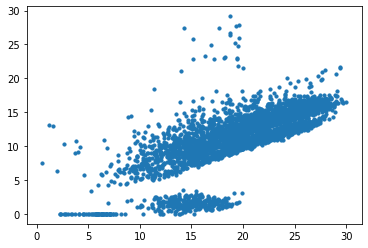

In [3]:
model, loss = train(
    model_, X, device=device, nb_iterations=10000, batch_size=len(X), lambda_kl=0
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_ae_10000.pth")
plot_latent(X, model, device)

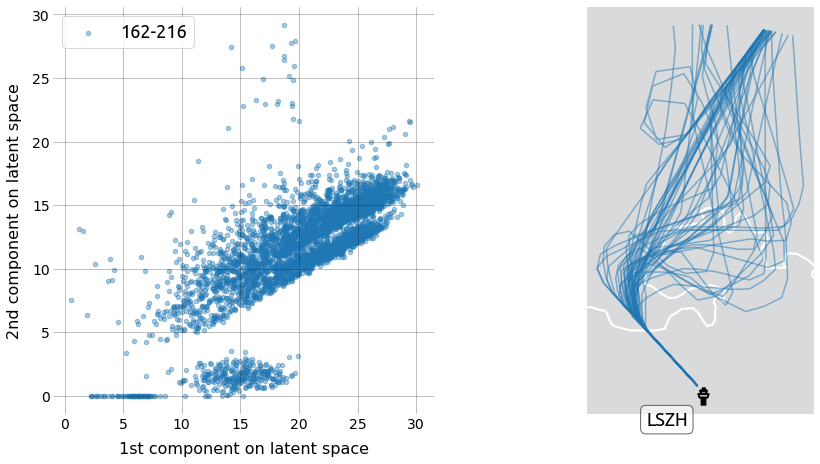

In [4]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_ae_10000.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, f"figs/{flow}_{runway}_latent_ae.png", runway=14)

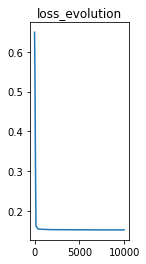

In [5]:
plot_loss(loss["loss"])

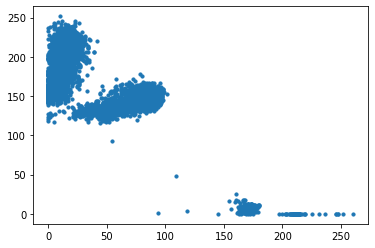

In [10]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.05
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_005.pth")
plot_latent(X, model, device)

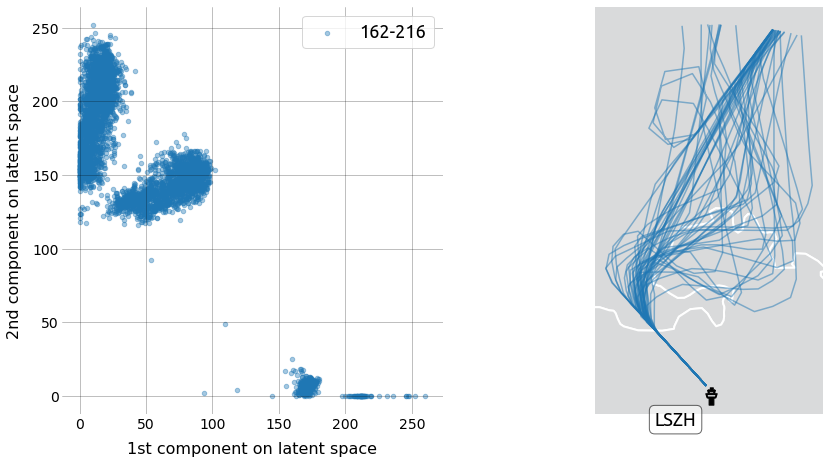

In [12]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_005.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(
    t, lat, f"figs/{flow}_{runway}_latent_tsne_500_005.png", runway=14
)

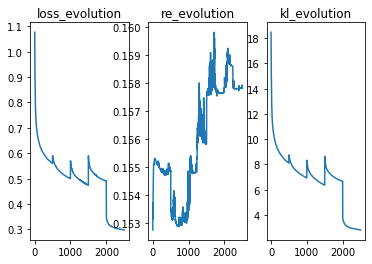

In [13]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

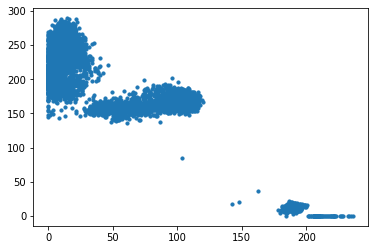

In [14]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.01
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_001.pth")
plot_latent(X, model, device)

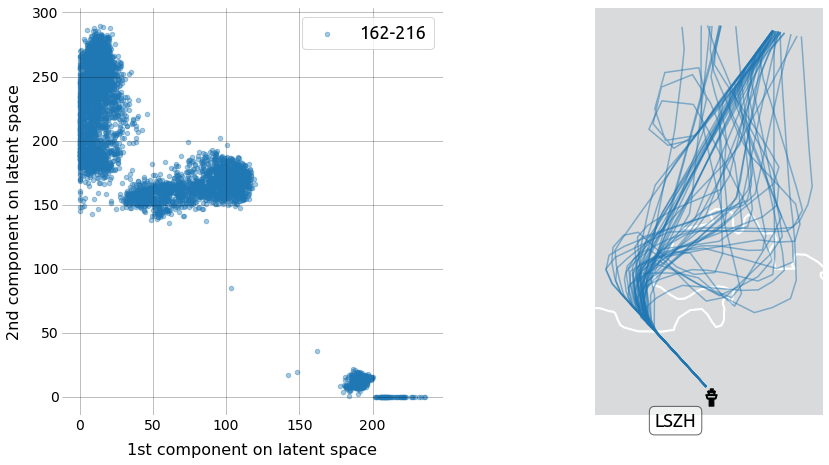

In [15]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_001.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(
    t, lat, f"figs/{flow}_{runway}_latent_tsne_500_001.png", runway=14
)

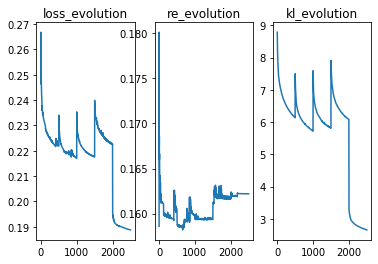

In [17]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

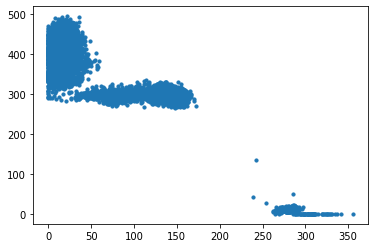

In [18]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.07
)
torch.save(model.state_dict(), f"models/{flow}_{runway}_tsne_500_007.pth")
plot_latent(X, model, device)

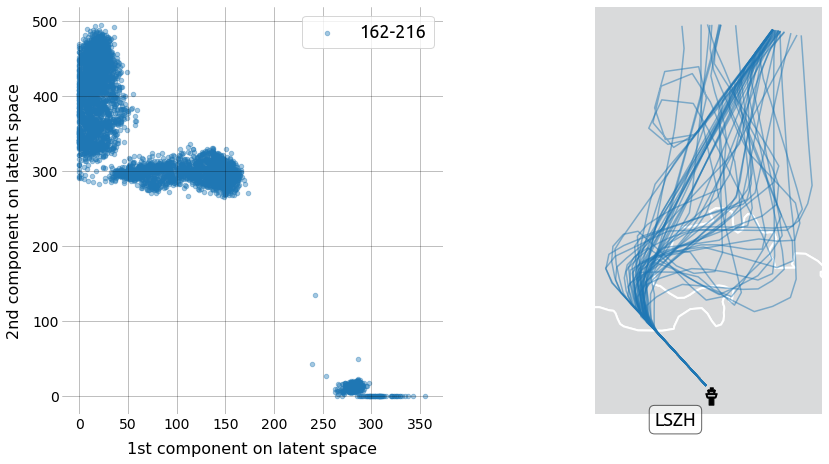

In [19]:
model.load_state_dict(torch.load(f"models/{flow}_{runway}_tsne_500_007.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, f"figs/{flow}_{runway}_latent_tsne.png", runway=14)

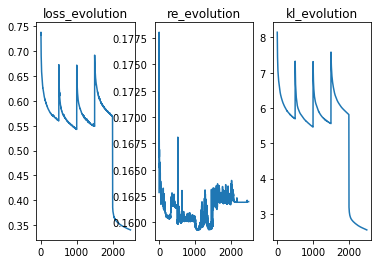

In [20]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from traffic.core import Traffic

from artefact import AutoencoderTSNE, Autoencoder

t = Traffic.from_file(f"data/lszh_{flow}_{runway}.parquet")
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
# list_features = ["longitude", "latitude"]

nb_flights = len(t)
nb_samples = len(t[0])
nb_features = len(list_features)
lambda_kl = 0.7
print(f"nb_flights: {len(t)}")

device = 2

algo_clustering = AutoencoderTSNE(
    gpu=device,
    batch_size=1000,
    model=Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    lambda_kl=lambda_kl,
    nb_iterations=800,
    algo_clustering=GaussianMixture(n_components=4),
    distance_trajectory="euclidean",  # delta_max
    savepath=f"models/model_{flow}_{runway}.pth",
)
model = algo_clustering.model

t_tsne = t.clustering(
    nb_samples=None,
    features=list_features,
    clustering=algo_clustering,
    transform=MinMaxScaler(feature_range=(-1, 1)),
).fit_predict()

t_tsne.to_pickle(f"test/t_tsne_{flow}_{runway}.pkl")
t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"})

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


nb_flights: 4437


,flight_id
cluster,
0,1721
1,1474
2,357
3,885


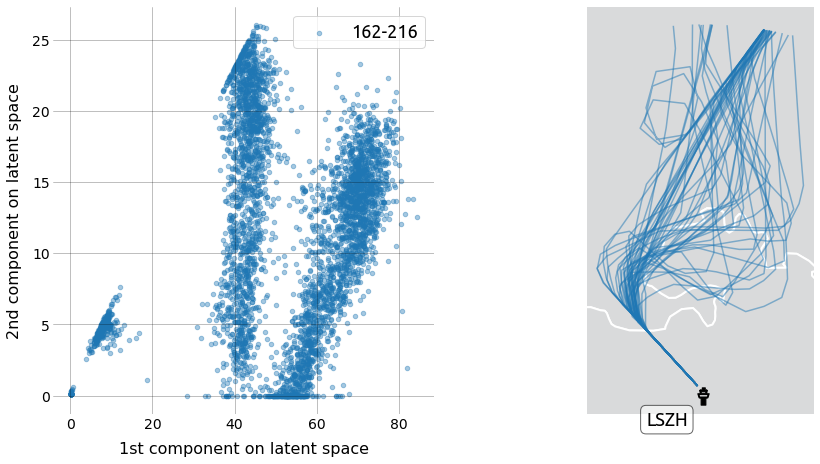

In [7]:
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t, algo_clustering.get_latent(), f"figs/{flow}_{runway}_latent.png", runway=14
)

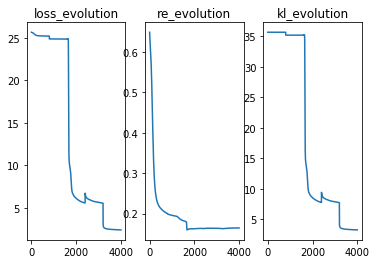

In [8]:
from artefact.plot import plot_loss

loss = algo_clustering.loss
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

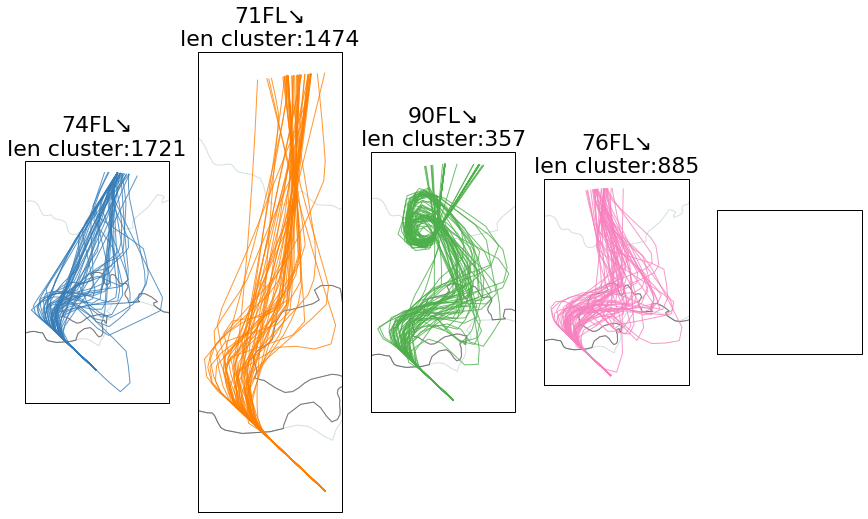

In [9]:
from traffic.core import Traffic
from artefact.plot import plot_trajs

t_tsne = Traffic.from_file(f"test/t_tsne_{flow}_{runway}.pkl")
plot_trajs(t_tsne, None)

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


        flight_id        re                    
          nunique      mean       min       max
cluster                                        
-1            417  0.171874  0.013691  0.705130
 0           1536  0.127815  0.000000  0.669343
 1           2136  0.159820  0.000741  1.000000
 2            285  0.161731  0.045407  0.322875
 3             63  0.407923  0.290287  0.611877


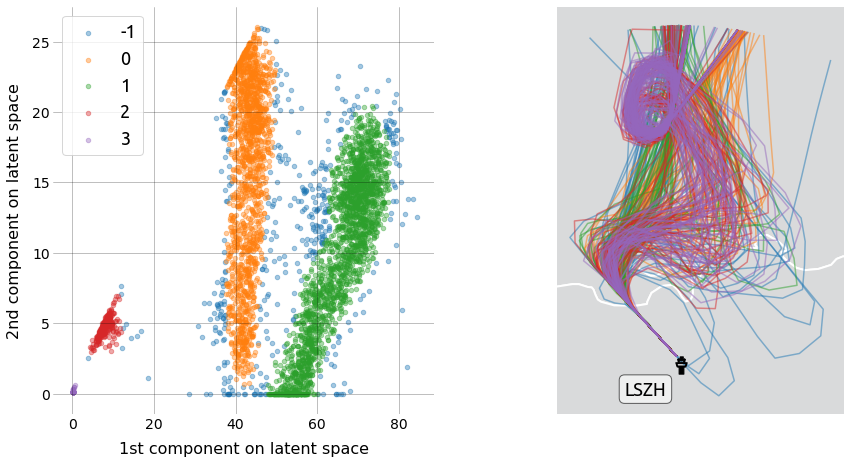

In [10]:
from sklearn.cluster import DBSCAN
from artefact import Autoencoder
from artefact.utils import pretrained_clust

eps, min_samples = 1.6, 40


def eps_f(eps):
    return str(eps).replace(".", "")


ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    DBSCAN(eps=eps, min_samples=min_samples),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_dbscan_{flow}_{runway}.pkl",
)
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t_tsne,
    ae_tsne.get_latent(),
    f"figs/{flow}_{runway}_latent_clusters_dbscan_{eps_f(eps)}_{min_samples}.png",
    plot_clusters=True,
    runway=14,
)

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


        flight_id        re                    
          nunique      mean       min       max
cluster                                        
0            1475  0.199807  0.044609  0.411381
1            1720  0.127600  0.000000  0.705130
2             885  0.105721  0.000741  1.000000
3             357  0.205635  0.045407  0.611877


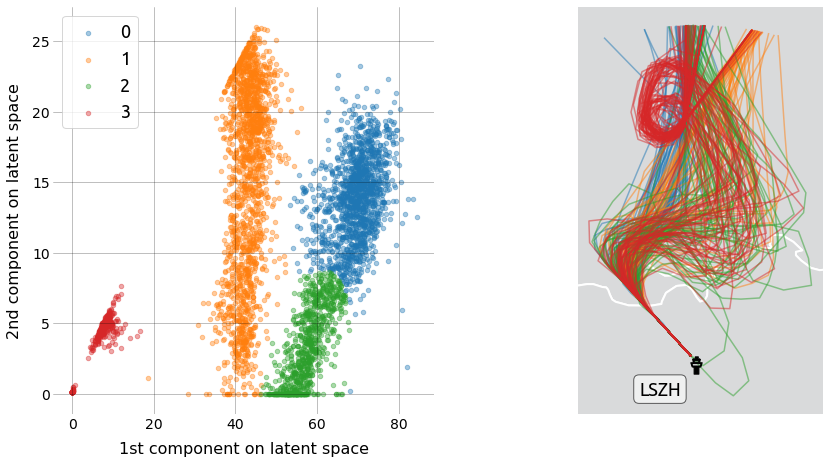

In [11]:
from sklearn.mixture import GaussianMixture
from artefact import Autoencoder
from artefact.utils import pretrained_clust

ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    GaussianMixture(n_components=4),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_gm_{flow}_{runway}.pkl",
)
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(
    t_tsne,
    ae_tsne.get_latent(),
    f"figs/{flow}_{runway}_latent_clusters_gm.png",
    plot_clusters=True,
    runway=14,
)

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:293: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


        flight_id        re                    
          nunique      mean       min       max
cluster                                        
0            1475  0.199807  0.044609  0.411381
1            1720  0.127600  0.000000  0.705130
2             357  0.205635  0.045407  0.611877
3             885  0.105721  0.000741  1.000000


top outliers
                      re
flight_id              
SWR109R_12259  1.000000
SWR116W_17131  0.705130
EWG7ME_1079    0.669343
SWR116W_17519  0.624256
SWR819_11922   0.611877
SWR1059_12421  0.525280
SWR89T_11930   0.519297
SWR169A_14922  0.516881
EWG764_1910    0.495038
SWR105K_17983  0.494938


/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


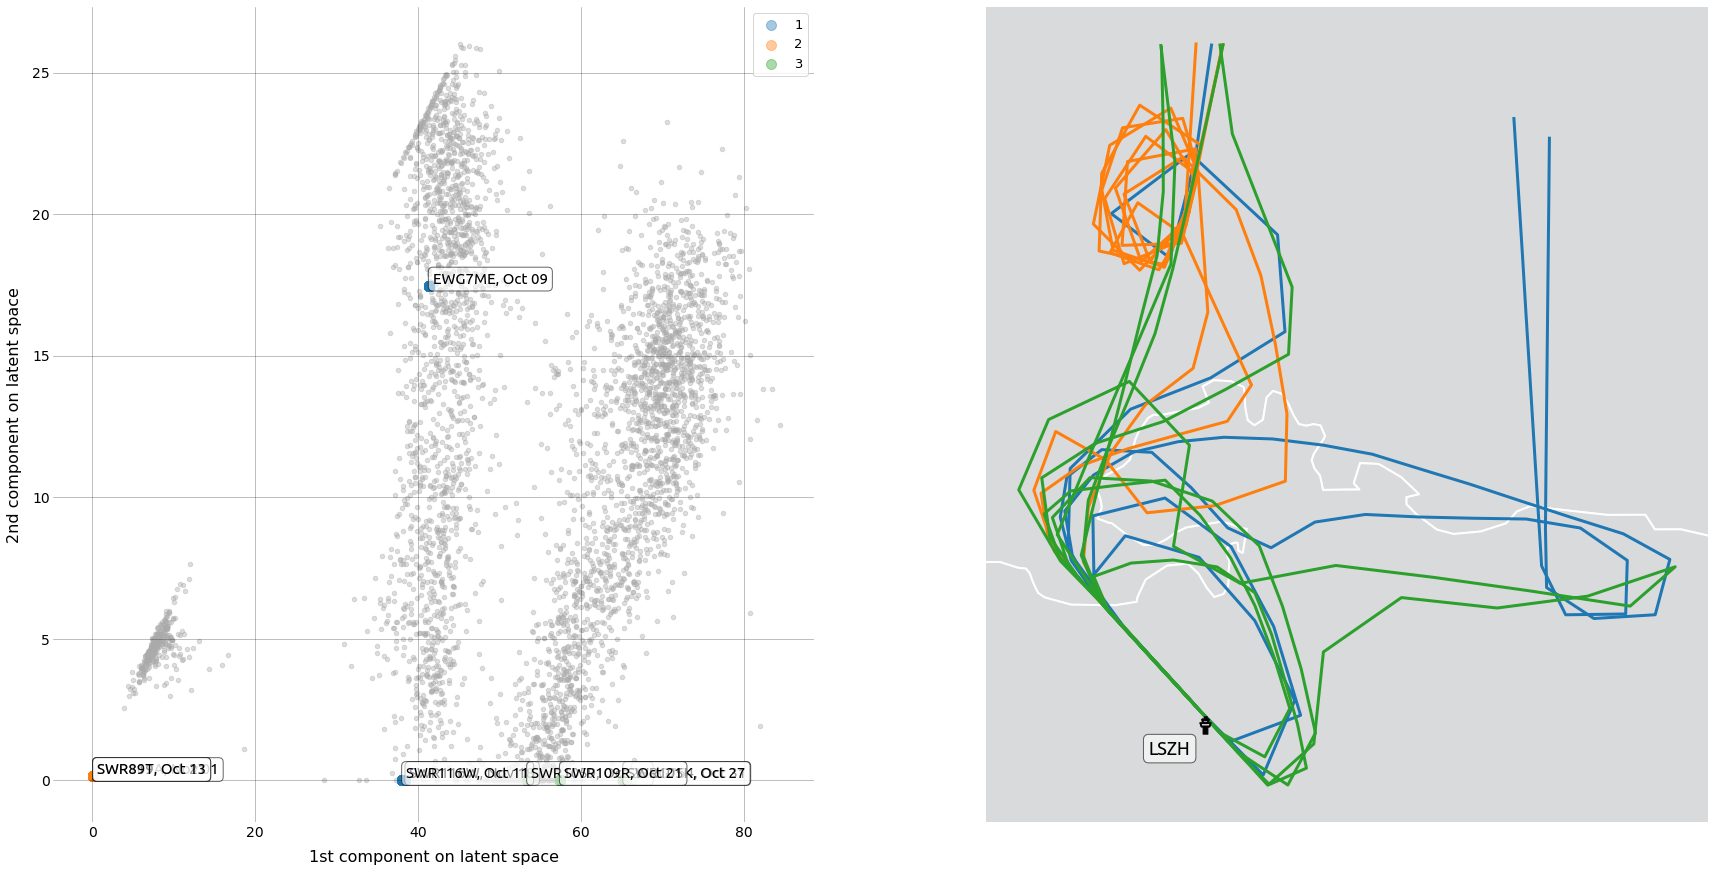

In [6]:
# outliers based on reconstruction error (re)
import numpy as np
from sklearn.mixture import GaussianMixture
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.utils import pretrained_clust
from artefact.plot import plot_latent_and_trajs_outliers

nb_samples = 30
flow = "162-216"
runway = "14"
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features= len(list_features)

ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    GaussianMixture(n_components=4),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_gm_{flow}_{runway}.pkl",
)

re = t_tsne.data.re
threshold = np.percentile(re, 95)
outliers = Traffic.from_flights(
    f for f in t_tsne if f.data.re.mean() > threshold
)

plot_latent_and_trajs_outliers(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl"),
    ae_tsne.get_latent(),
    outliers,
    f"figs/{flow}_{runway}_latent_clusters_outliers_re_gm.png",
    nb_top_outliers=10,
    plot_callsigns=True,
)

/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


        flight_id        re                         score                    
          nunique      mean       min       max      mean       min       max
cluster                                                                      
0            1473  0.199954  0.044609  0.411381  0.960232  0.441829  0.990763
1             886  0.105645  0.000741  1.000000  0.959128  0.700445  0.987476
2             357  0.205635  0.045407  0.611877  0.966572  0.255199  1.000000
3            1721  0.127611  0.000000  0.705130  0.948194  0.000000  0.981607


top outliers
                   score
flight_id              
SWR729_7748    0.821931
SWR145N_11828  0.821927
EFD4E_2230     0.820399
SWR108Z_11161  0.820251
SWR74A_10825   0.819063
EWG9AP_1065    0.818375
WGT2B_1476     0.816957
SWR1271_9390   0.814417
SWR109A_6997   0.813798
KLM21W_4688    0.813392


/home/luis/.conda/envs/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


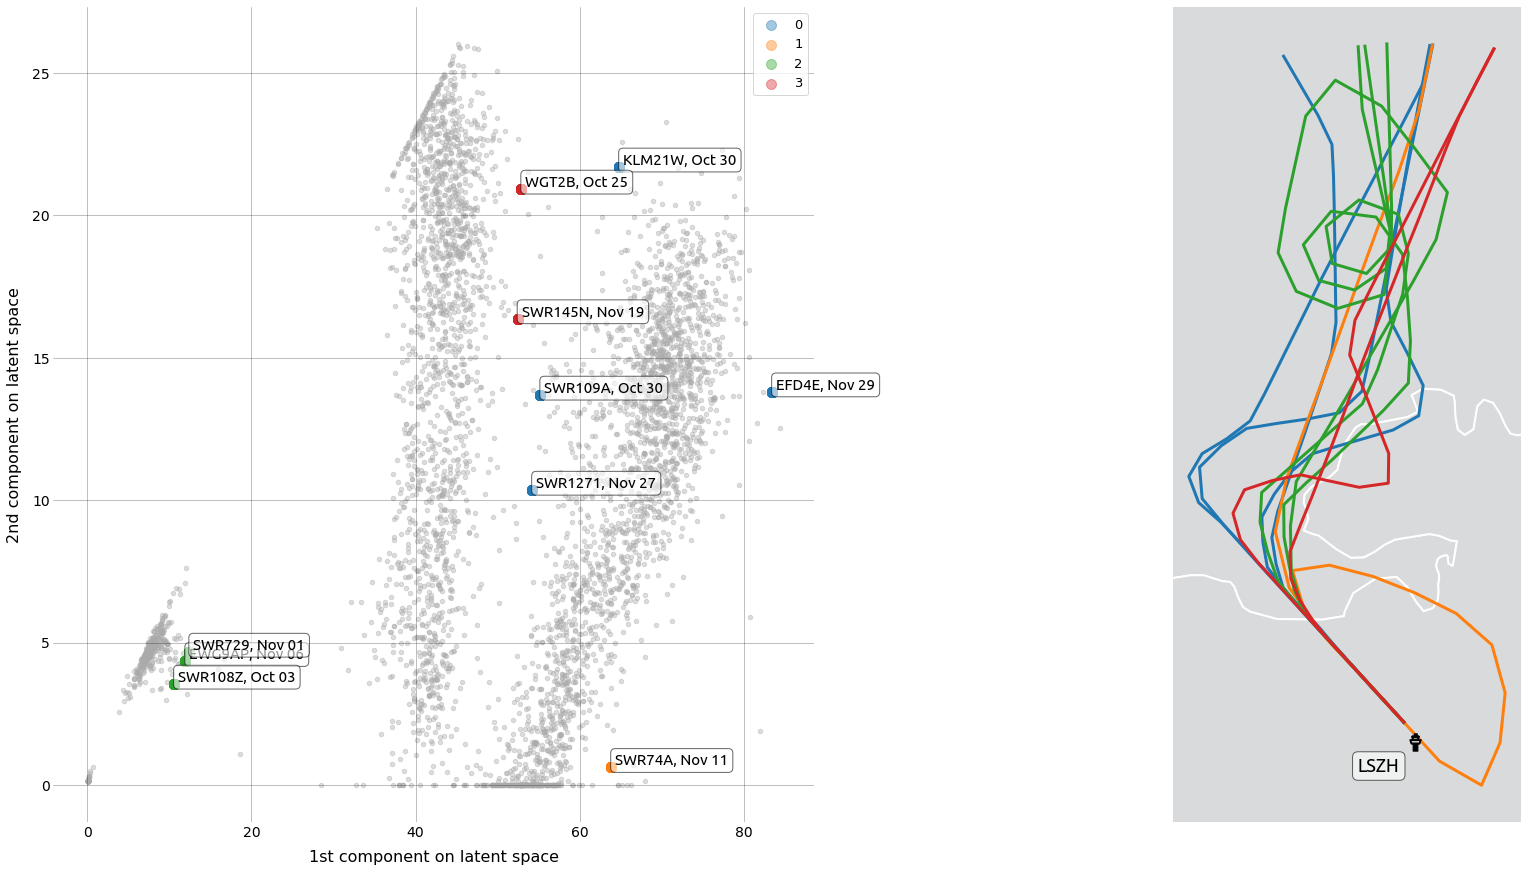

In [6]:
# outliers based on GMM score 
import numpy as np
from sklearn.mixture import GaussianMixture
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.utils import pretrained_clust
from artefact.plot import plot_latent_and_trajs_outliers

nb_samples = 30
flow = "162-216"
runway = "14"
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features= len(list_features)

ae_tsne, t_tsne = pretrained_clust(
    f"data/lszh_{flow}_{runway}.parquet",
    list_features,
    GaussianMixture(n_components=4),
    Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    f"models/model_{flow}_{runway}.pth",
    f"test/t_tsne_gm_{flow}_{runway}.pkl",
)

scores = t_tsne.data.score
threshold = np.percentile(scores, 1)
outliers = Traffic.from_flights(
    f for f in t_tsne if f.data.score.mean() < threshold
)

plot_latent_and_trajs_outliers(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl"),
    ae_tsne.get_latent(),
    outliers,
    f"figs/{flow}_{runway}_latent_clusters_outliers_score_gm.png",
    nb_top_outliers=10,
    plot_callsigns=True,
    re_or_score="score",
)

In [15]:
from traffic.core import Traffic
from artefact.utils import duration_cumdist_cluster

flow = "162-216"
runway = "14"

dur_dist = duration_cumdist_cluster(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl")
)
dur_dist

,flight_id,duration,cumdist
cluster,,,
0,1475,11.074576,25.019608
1,1720,12.926744,27.899726
2,885,14.674576,30.401245
3,357,20.330532,41.118506


In [16]:
duration_cumdist_cluster(outliers)

,flight_id,duration,cumdist
cluster,,,
0,117,10.572650,25.177766
1,15,23.800000,47.610665
2,19,23.052632,48.077207
3,70,25.157143,50.812141


In [22]:
from artefact.utils import duration_cumdist_flight
from artefact.plot import dur_dist_plot

dur_dist = duration_cumdist_flight(outliers)
dur_dist_plot(dur_dist)

alt.Chart(...)

In [4]:
from traffic.core import Traffic
from artefact.utils import duration_cumdist_flight
from artefact.plot import dur_dist_plot

flow = "162-216"
runway = "14"

dur_dist = duration_cumdist_flight(
    Traffic.from_file(f"test/t_tsne_gm_{flow}_{runway}.pkl")
)
dur_dist_plot(dur_dist)

alt.Chart(...)